#### Non-small cell lung cancer (NSCLC) is histologically divided into adenocarcinoma, squamous cell carcinoma, and large-cell carcinoma. Lung adenocarcinoma (LUAD) is the most common type, accounting for approximately 40% of all lung cancers. LUAD is often detected at the metastatic stage with prevalence in the brain, bones, and respiratory system. Distant metastasis is the major cause of mortality in lung cancer; however, specific aspects of metastatic lung cancer and its associated microenvironments remain poorly understood. 

#### Efforts made for the understanding of lung cancer progression and metastasis have largely focused on profiling of cancer cells with genetic aberrations. However, progression and metastasis are also influenced by complex and dynamic features in tumor surroundings.

#### To investigate stromal cell dynamics in the tumor microenvironment we will focus on endothelial cells. With the knowledge you already have in single cell analysis, determine de subclusters comprised in this endothelial population and if any of them are related to the tumor

#### Import scanpy, numpy, scipy, pandas, csv, matplotlib and seaborn libraries

In [2]:
import scanpy as sc
import numpy as np
import scipy as sp
import pandas as pd
import csv as csv
import seaborn as sb

In [3]:
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib import colors
import gc
from gprofiler import GProfiler

In [4]:
from scipy import sparse

#### Read the files barcode.csv, varnames.csv and matrix.gz

In [5]:
matrix = sparse.load_npz('/home/fredo/Desktop/AMMLab/Practica_Regulacion_Genica/matrix/endothelial_matrix.npz')
barcodes = pd.read_csv('/home/fredo/Desktop/AMMLab/Practica_Regulacion_Genica/matrix/endothelial_barcodes.csv')
varnames = pd.read_csv('/home/fredo/Desktop/AMMLab/Practica_Regulacion_Genica/matrix/endothelial_varnames.csv')

#### Create the anndata object

In [6]:
adata = sc.AnnData(X=matrix, obs=barcodes, var=varnames)

/home/fredo/anaconda3/envs/VINC_RNAseq/lib/python3.8/site-packages/anndata/_core/anndata.py:117: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [7]:
adata.obs_names = list(adata.obs['obs_names'])
adata.var_names = list(adata.var['var_names'])

##### How many cells and genes do we have?

In [8]:
adata.n_obs

2107

In [9]:
adata.n_vars

20599

##### How many samples do we have?

In [10]:
adata.obs['sample'] = adata.obs['sample'].astype('category')

In [11]:
len(adata.obs['sample'].cat.categories)

36

##### Which is the sample with more number of cells? And with lower?

In [12]:
adata.obs['sample'].value_counts()

LUNG_N19      395
LUNG_N30      180
LUNG_N18      173
LUNG_N31      164
LUNG_T19      159
LUNG_T30      145
LUNG_T31      135
LUNG_N08      112
LUNG_N34       88
LUNG_N20       75
NS_04          58
LUNG_N09       57
LUNG_T06       51
LUNG_N01       32
LUNG_T25       30
LUNG_T28       29
LUNG_T09       28
NS_19          27
NS_07          24
NS_17          20
LUNG_T34       19
LUNG_T18       17
BRONCHO_58     12
LUNG_T08       12
NS_12          12
LUNG_N28       11
LUNG_N06        8
NS_03           7
NS_13           5
EBUS_10         4
EBUS_28         4
BRONCHO_11      4
NS_06           3
NS_16           3
EBUS_06         2
LUNG_T20        2
Name: sample, dtype: int64

### Filtering genes

In [13]:
#prefilter_var = int(adata.n_vars)
#print(f'Original number of genes:', prefilter_var)
sc.pp.filter_genes(adata, min_cells=10)
#print(f'Number of genes after quality control:{adata.n_vars}')
#print(f'Number of genes removed:', prefilter_var-adata.n_vars)

##### How many genes are removed after filtering?

##### Why does this filter remove X number of genes? Taking into account the data we downloaded with all the celltypes was already filtered

#### Determine HVGs. In this case, select as top genes the 10% of the total genes

In [14]:
sc.pp.highly_variable_genes(adata, flavor='seurat', n_top_genes=int(adata.n_vars*0.1))
print('\n','Number of highly variable genes: {:d}'.format(np.sum(adata.var['highly_variable'])))


 Number of highly variable genes: 1392


### Dimensionality reduction

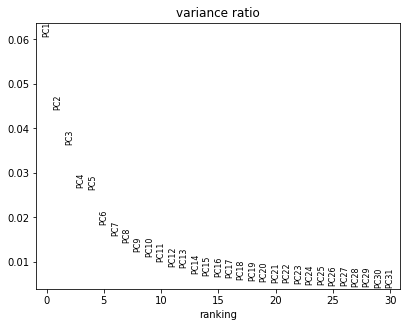

In [15]:
sc.pp.pca(adata, n_comps=50, use_highly_variable=True, svd_solver='arpack')
sc.pl.pca_variance_ratio(adata, log=False)

In [16]:
sc.pp.pca(adata, n_comps=15, use_highly_variable=True, svd_solver='arpack')

#### neighbors 

##### Estimate neighbors with size of the local neighborhood = 10

In [17]:
sc.pp.neighbors(adata, n_neighbors=10)

### Dimensionality reduction (visualization)

In [18]:
sc.tl.umap(adata)
#sc.tl.tsne(adata)

In [19]:
adata

AnnData object with n_obs × n_vars = 2107 × 13922
    obs: 'Unnamed: 0', 'Barcode', 'barcode', 'cellsubtype', 'celltype', 'celltype_refined', 'index', 'n_counts', 'obs_names', 'origin', 'sample'
    var: 'Unnamed: 0', 'dispersions', 'dispersions_norm', 'highly_variable', 'means', 'n_cells', 'var_names'
    uns: 'hvg', 'pca', 'neighbors', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

##### Is there any bias related to sample origin? E.g: It seems like a group of cells from mLN samples cluster together

/home/fredo/.local/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:378: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


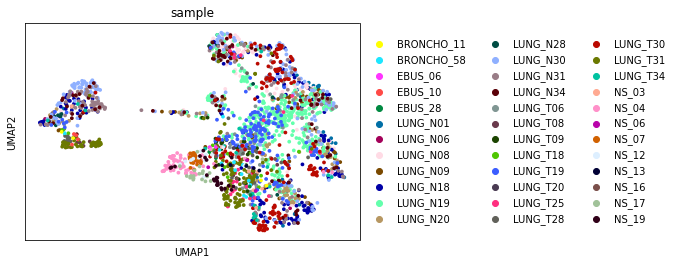

In [20]:
plt.rcParams['figure.facecolor'] = 'white'
sc.pl.umap(adata, color = 'sample')

### Clustering

In [21]:
sc.tl.louvain(adata, resolution = 0.2, key_added = 'louvain2', random_state = 0) # resolution 0.1 y resolution 0.25

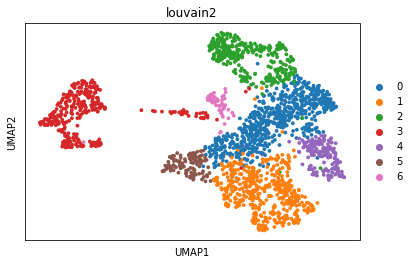

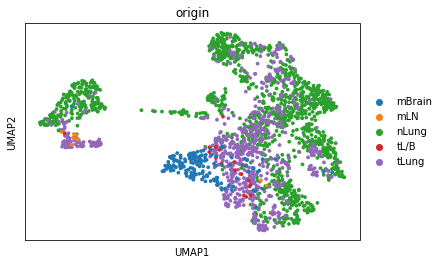

In [22]:
sc.pl.umap(adata, color = 'louvain2')
sc.pl.umap(adata, color = 'origin')

In [23]:
adata

AnnData object with n_obs × n_vars = 2107 × 13922
    obs: 'Unnamed: 0', 'Barcode', 'barcode', 'cellsubtype', 'celltype', 'celltype_refined', 'index', 'n_counts', 'obs_names', 'origin', 'sample', 'louvain2'
    var: 'Unnamed: 0', 'dispersions', 'dispersions_norm', 'highly_variable', 'means', 'n_cells', 'var_names'
    uns: 'hvg', 'pca', 'neighbors', 'umap', 'sample_colors', 'louvain', 'louvain2_colors', 'origin_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

##### Which is the cluster with more number of cells? How many does it have?

In [24]:
adata.obs['louvain2'].value_counts()

0    650
1    471
2    326
3    322
4    173
5    113
6     52
Name: louvain2, dtype: int64

### Annotation

#### Determine the marker genes for each cluster

In [25]:
sc.tl.rank_genes_groups(adata, groupby='louvain2', key_added='rank_genes_groups', method='wilcoxon', corr_method = 'benjamini-hochberg',
                        groups = 'all', reference = 'rest')

In [26]:
cero_markers = sc.get.rank_genes_groups_df(adata, group='0', key='rank_genes_groups', pval_cutoff=1e-10, log2fc_min=0.5)
cero_markers['cluster'] = ['0']*len(cero_markers)

uno_markers = sc.get.rank_genes_groups_df(adata, group='1', key='rank_genes_groups', pval_cutoff=1e-10, log2fc_min=0.5)
uno_markers['cluster'] = ['1']*len(uno_markers)

dos_markers = sc.get.rank_genes_groups_df(adata, group='2', key='rank_genes_groups', pval_cutoff=1e-10, log2fc_min=0.5)
dos_markers['cluster'] = ['2']*len(dos_markers)

tres_markers = sc.get.rank_genes_groups_df(adata, group='3', key='rank_genes_groups', pval_cutoff=1e-10, log2fc_min=0.5)
tres_markers['cluster'] = ['3']*len(tres_markers)

cuatro_markers = sc.get.rank_genes_groups_df(adata, group='4', key='rank_genes_groups', pval_cutoff=1e-10, log2fc_min=0.5)
cuatro_markers['cluster'] = ['4']*len(cuatro_markers)

cinco_markers = sc.get.rank_genes_groups_df(adata, group='5', key='rank_genes_groups', pval_cutoff=1e-10, log2fc_min=0.5)
cinco_markers['cluster'] = ['5']*len(cinco_markers)

seis_markers = sc.get.rank_genes_groups_df(adata, group='6', key='rank_genes_groups', pval_cutoff=1e-10, log2fc_min=0.5)
seis_markers['cluster'] = ['6']*len(seis_markers)

In [27]:
gc.collect()

12566

##### Estimate the logfoldchanges for each marker in the resulting clusters and plot the top 10 markers for each one taking into account the logfoldchanges values

In [28]:
cero_markers = sc.get.rank_genes_groups_df(adata, group='0', key='rank_genes_groups', pval_cutoff=1e-10, log2fc_min=0.5)
cero_markers['cluster'] = ['0']*len(cero_markers)

uno_markers = sc.get.rank_genes_groups_df(adata, group='1', key='rank_genes_groups', pval_cutoff=1e-10, log2fc_min=0.5)
uno_markers['cluster'] = ['1']*len(uno_markers)

dos_markers = sc.get.rank_genes_groups_df(adata, group='2', key='rank_genes_groups', pval_cutoff=1e-10, log2fc_min=0.5)
dos_markers['cluster'] = ['2']*len(dos_markers)

tres_markers = sc.get.rank_genes_groups_df(adata, group='3', key='rank_genes_groups', pval_cutoff=1e-10, log2fc_min=0.5)
tres_markers['cluster'] = ['3']*len(tres_markers)

cuatro_markers = sc.get.rank_genes_groups_df(adata, group='4', key='rank_genes_groups', pval_cutoff=1e-10, log2fc_min=0.5)
cuatro_markers['cluster'] = ['4']*len(cuatro_markers)

cinco_markers = sc.get.rank_genes_groups_df(adata, group='5', key='rank_genes_groups', pval_cutoff=1e-10, log2fc_min=0.5)
cinco_markers['cluster'] = ['5']*len(cinco_markers)

seis_markers = sc.get.rank_genes_groups_df(adata, group='6', key='rank_genes_groups', pval_cutoff=1e-10, log2fc_min=0.5)
seis_markers['cluster'] = ['6']*len(seis_markers)

### Select 'de novo' markers

##### Cluster number 0

In [30]:
cero_markers.sort_values('logfoldchanges', ascending=False)

,names,scores,logfoldchanges,pvals,pvals_adj,cluster
0,FCN3,20.243622,4.585464,4.043367e-91,5.629176e-87,0
2,RGCC,19.811741,3.290380,2.357850e-87,1.094200e-83,0
13,IL7R,13.196586,3.189502,9.180222e-40,7.100392e-37,0
58,ESM1,9.055098,3.141673,1.364462e-19,1.880796e-17,0
15,ENPP2,12.802890,2.942613,1.579623e-37,1.099576e-34,0
...,...,...,...,...,...,...
64,ACTG1,8.731720,0.659838,2.508280e-18,3.036545e-16,0
29,H3F3A,10.925427,0.635064,8.712965e-28,2.527123e-25,0
39,MYL6,10.280301,0.617075,8.645699e-25,1.880710e-22,0
47,B2M,9.710186,0.596641,2.728400e-22,4.869844e-20,0


##### Which are the top 3 markers for this cluster? (Taking into account the logfoldchange)

##### Heatmap with 3 best markers for each cluster

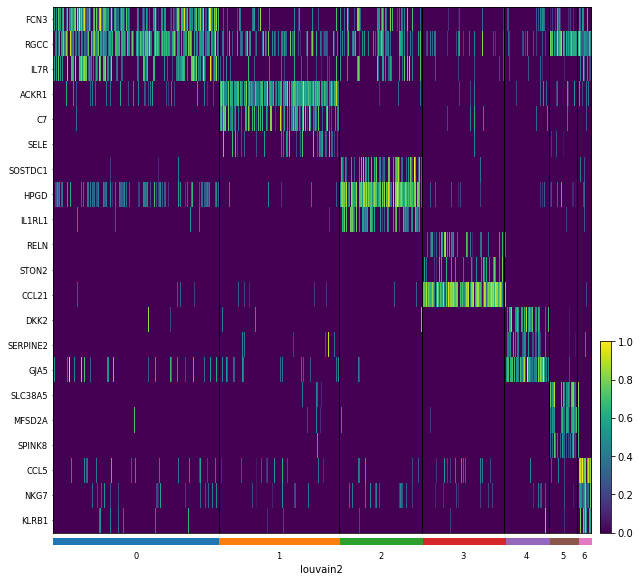

In [34]:
sc.pl.heatmap(adata, list(cero_markers.sort_values('logfoldchanges', ascending=False).names[0:3])+
              list(uno_markers.sort_values('logfoldchanges', ascending=False).names[0:3])+
              list(dos_markers.sort_values('logfoldchanges', ascending=False).names[0:3])+
              list(tres_markers.sort_values('logfoldchanges', ascending=False).names[0:3])+
              list(cuatro_markers.sort_values('logfoldchanges', ascending=False).names[0:3])+
              list(cinco_markers.sort_values('logfoldchanges', ascending=False).names[0:3])+
              list(seis_markers.sort_values('logfoldchanges', ascending=False).names[0:3])
              , swap_axes=True,
              groupby = 'louvain2', standard_scale='var', figsize=[10,10])

### Markers highlighted in the original article

Markers: 
    Tumor cells: 'INSR','HSPG2','VWA1'
    Tip-like cells: 'RGCC','RAMP3','ADM'
    Stalk-like cells: 'ACKR1','SELP'
    EPCs: 'TYROBP','C1QB'
    Lymphatic: 'LYVE1','PROX1'

In [35]:
markers = pd.concat([cero_markers, uno_markers, dos_markers, tres_markers, cuatro_markers, cinco_markers, seis_markers])

In [36]:
markers[markers.names.str.contains('|'.join(['INSR','HSPG2','VWA1',
                                             'RGCC','RAMP3','ADM',
                                             'ACKR1','SELP',
                                             'TYROBP','C1QB',
                                             'LYVE1','PROX1']))]

,names,scores,logfoldchanges,pvals,pvals_adj,cluster
2,RGCC,19.811741,3.290380,2.357850e-87,1.094200e-83,0
0,ACKR1,27.593037,7.256052,1.348761e-167,1.877745e-163,1
21,SELP,14.122296,3.286395,2.768220e-45,1.482275e-42,1
26,HSPG2,13.867064,2.089688,1.002997e-43,4.363665e-41,1
70,RAMP3,11.062339,1.664445,1.910502e-28,3.204579e-26,1
68,RAMP3,7.479579,1.269346,7.456095e-14,4.054834e-12,2
9,PROX1,18.449625,7.783819,5.250789e-76,3.847446e-73,3
120,LYVE1,10.380383,2.458259,3.045491e-25,2.342504e-23,3
6,INSR,11.235676,4.275196,2.724002e-29,2.708825e-26,5
19,RGCC,9.960044,3.225972,2.279628e-23,1.094379e-20,5


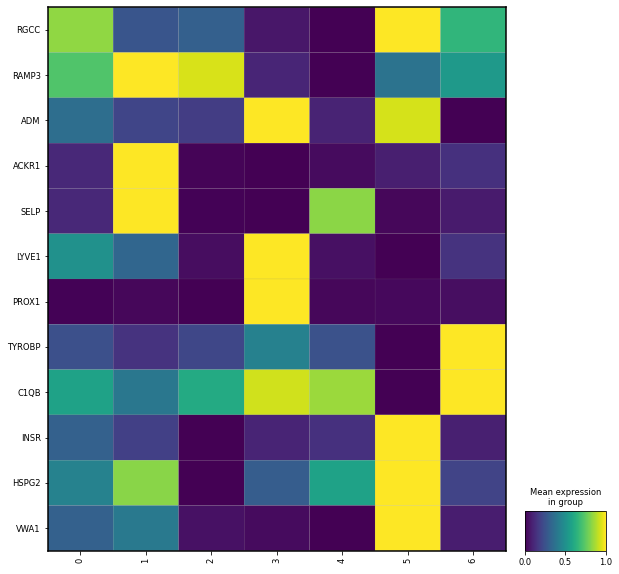

In [37]:
sc.pl.matrixplot(adata, ['RGCC','RAMP3','ADM',
                         'ACKR1','SELP',
                         'LYVE1','PROX1',
                         'TYROBP','C1QB',
                         'INSR','HSPG2','VWA1'], 
                 groupby='louvain2', swap_axes=True, figsize=[10,10], standard_scale='var')

##### Are the markers highlighted in the article for each cluster the best defining these populations?

#### Tumor markers

##### Which cluster is the one with more representation of tumor markers?

In [38]:
tumor_markers = str('INSR,HSPG2,VWA1,PLVAP,IGHG3,IGKC,SPRY1,COL4A1,IGLC2,IGFBP7,COL15A1,SPARC,COL4A2,CTGF,ACKR1,HTRA1,ANGPT2,ABCG2,SAT1,GSN,MLEC,A2M')
tumor_markers = tumor_markers.split(',')
len(tumor_markers)
markers[markers.names.str.contains('|'.join(tumor_markers))].cluster.value_counts()

5    13
1     9
0     6
2     1
3     1
Name: cluster, dtype: int64